## Setup

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action = "ignore")

# External modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/isuelogit


In [3]:
# Internal modules
from src import isuelogit as isl

## Read network data from tntp repository

In [4]:
network_name = 'SiouxFalls'

# Reporter of estimation results
estimation_reporter = isl.writer.Reporter(
    folderpath=isl.config.dirs['output_folder'] + 'estimations/' + network_name, seed = 2022)

## Read data from tntp repository

In [5]:
links_df = isl.reader.read_tntp_linkdata(network_name=network_name)

links_df['link_key'] = [(i, j, '0') for i, j in zip(links_df['init_node'], links_df['term_node'])]

## Build network

In [6]:
network_generator = isl.factory.NetworkGenerator()

A = network_generator.generate_adjacency_matrix(links_keys=list(links_df['link_key'].values))

tntp_network = network_generator.build_network(A=A,network_name=network_name)


Creating SiouxFalls network

Nodes: 24, Links: 76


### Link performance functions

In [7]:
bpr_parameters_df = pd.DataFrame({'link_key': tntp_network.links_dict.keys(),
                                  'alpha': links_df.b,
                                  'beta': links_df.power,
                                  'tf': links_df.free_flow_time,
                                  'k': links_df.capacity
                                  })

tntp_network.set_bpr_functions(bprdata=bpr_parameters_df)

### Exogenous link attributes

In [8]:
# Link features from TNTP repo

link_features_df = links_df[['link_key','length', 'speed', 'link_type', 'toll']]

# Synthetic link features

linkdata_generator = isl.factory.LinkDataGenerator()

synthetic_features_df = linkdata_generator.simulate_features(links=tntp_network.links,
                                                             features_Z= ['c', 'w', 's'],
                                                             option='continuous',
                                                             range=(0, 1))
# Sparse features

n_sparse_features = 1 

sparse_features_labels = ['k' + str(i) for i in np.arange(0, n_sparse_features)]

sparse_features_df = linkdata_generator.simulate_features(
    links=tntp_network.links,
    features_Z=sparse_features_labels,
    option='continuous',
    range=(-1, 1))

# Merge dataframes with existing dataframe
link_features_df = link_features_df.merge(synthetic_features_df, left_on='link_key', right_on='link_key')
link_features_df = link_features_df.merge(sparse_features_df, left_on='link_key', right_on='link_key')

# Load features data
tntp_network.load_features_data(linkdata=link_features_df)

### Utility function

In [9]:
utility_function = isl.estimation.UtilityFunction(features_Y=['tt'],
                                                  features_Z=['c', 's'],
                                                  true_values={'tt': -1, 'c': -6, 's': -3}
                                                  )

# Add parameters for sparse features
utility_function.add_sparse_features(Z=sparse_features_labels)

### OD matrix

In [10]:
Q = isl.reader.read_tntp_od(network_name=network_name)

tntp_network.load_OD(Q= Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.6[s]
360600.0 trips were loaded among 528 o-d pairs


## Paths

In [11]:
paths_generator = isl.factory.PathsGenerator()

paths_generator.load_k_shortest_paths(network=tntp_network, k=3)

Generating at most 3 paths per od
1584 paths were generated among 528 od pairs in 0.8 [s]
1584 paths were loaded in the network
Updating incidence matrices
Matrix D (76, 1584) generated in 0.4[s].0% 
Matrix M (528, 1584) generated in 0.2[s]0% 
Matrix C (1584, 1584) generated in 0.0[s]


### Equilibrator

In [12]:
equilibrator = isl.equilibrium.LUE_Equilibrator(network=tntp_network,
                                                utility_function=utility_function,
                                                uncongested_mode=False,
                                                max_iters=100,
                                                method='fw',
                                                iters_fw=100,
                                                search_fw='grid')

### Synthetic traffic counts

In [13]:
counts, _ = linkdata_generator.simulate_counts(network=tntp_network,
                                               equilibrator=equilibrator,
                                               noise_params={'mu_x': 0, 'sd_x': 0},
                                               coverage=0.75)
tntp_network.load_traffic_counts(counts=counts)


Generating synthetic link counts via Frank-Wolfe

SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-01', '3E-02', '2E-02', '9E-03', '2E-02', '8E-03', '2E-03', '2E-03', '2E-03', '1E-03', '8E-04', '5E-04', '5E-04', '3E-04', '6E-04', '4E-04', '9E-04', '4E-04', '1E-06']
Initial Fisk Objective: -16,573,721.14
Final Fisk Objective: -7,526,416.84
Improvement Fisk Objective: 54.59%
Final gap: 1E-06. Acc. bound: 1E-04. Time: 14.1 [s]
Ratio of counts versus capacity: 101.1%
Proportion of links over capacity: 53.9%
Normalized RMSE: 0.0


## Descriptive statistics

### Network topology

In [14]:
isl.descriptive_statistics.summary_table_networks([tntp_network])

,network,nodes,links,ods,paths
0,SiouxFalls,24,76,528,1584


### Links data

In [15]:
summary_table_links_df = tntp_network.Z_data
estimation_reporter.write_table(df = summary_table_links_df, filename = 'links_data.csv', float_format = '%.3f')
summary_table_links_df

,link_type,alpha,beta,tf,k,length,speed,toll,c,w,s,k0
0,1,0.15,4.0,6.0,25900.200640,6,0,0,0.009359,0.776799,0.096403,-0.694451
1,1,0.15,4.0,4.0,23403.473190,4,0,0,0.499058,0.096330,0.103100,0.865162
2,1,0.15,4.0,6.0,25900.200640,6,0,0,0.113384,0.966162,0.628923,0.416777
3,1,0.15,4.0,5.0,4958.180928,5,0,0,0.049974,0.322264,0.937743,0.795567
4,1,0.15,4.0,4.0,23403.473190,4,0,0,0.685408,0.293168,0.822726,-0.300989
...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0.15,4.0,4.0,5000.000000,4,0,0,0.853911,0.089076,0.573723,0.411416
72,1,0.15,4.0,2.0,5078.508436,2,0,0,0.401445,0.252352,0.331158,-0.079300
73,1,0.15,4.0,4.0,5091.256152,4,0,0,0.388206,0.695309,0.543184,-0.517812
74,1,0.15,4.0,3.0,4885.357564,3,0,0,0.884407,0.479084,0.968118,0.643136


In [16]:
summary_table_links_df.describe()

,link_type,alpha,beta,tf,k,length,speed,toll,c,w,s,k0
count,76.0,76.00,76.0,76.000000,76.000000,76.000000,76.0,76.0,76.000000,76.000000,76.000000,76.000000
mean,1.0,0.15,4.0,4.131579,10247.206327,4.131579,0.0,0.0,0.500360,0.471362,0.541126,0.007762
std,0.0,0.00,0.0,1.730835,7358.655049,1.730835,0.0,0.0,0.315522,0.308235,0.311072,0.578249
min,1.0,0.15,4.0,2.000000,4823.950831,2.000000,0.0,0.0,0.008125,0.004125,0.037977,-0.983713
25%,1.0,0.15,4.0,3.000000,4958.180928,3.000000,0.0,0.0,0.247219,0.202505,0.243093,-0.518533
50%,1.0,0.15,4.0,4.000000,5109.391136,4.000000,0.0,0.0,0.492546,0.450669,0.570230,0.013101
75%,1.0,0.15,4.0,5.000000,14564.753150,5.000000,0.0,0.0,0.785213,0.753938,0.811681,0.540863
max,1.0,0.15,4.0,10.000000,25900.200640,10.000000,0.0,0.0,0.988794,0.988080,0.999948,0.877657


### Benchmark predictions

In [17]:
mean_counts_prediction_loss, mean_count_benchmark_model, \
    = isl.estimation.mean_count_prediction(counts=np.array(list(counts.values()))[:, np.newaxis])

print('\nObjective function under mean count prediction: ' + '{:,}'.format(round(mean_counts_prediction_loss, 1)))

equilikely_prediction_loss, x_eq_equilikely \
    = isl.estimation.loss_counts_equilikely_choices(
    network = tntp_network,
    equilibrator=equilibrator,
    counts=tntp_network.counts_vector,
    utility_function=utility_function)

print('Objective function under equilikely route choices: ' + '{:,}'.format(round(equilikely_prediction_loss, 1)))


Objective function under mean count prediction: 1,191,820,506.1
Objective function under equilikely route choices: 1,871,377,870.5


## Bilevel Estimation

In [18]:
outer_optimizer_norefined = isl.estimation.OuterOptimizer(method='ngd',iters=1, eta=1e-1)

learner_norefined = isl.estimation.Learner(
    equilibrator=equilibrator,
    outer_optimizer=outer_optimizer_norefined,
    utility_function=utility_function,
    network=tntp_network,
    name='norefined')

outer_optimizer_refined = isl.estimation.OuterOptimizer(method='lm', iters=1)

learner_refined = isl.estimation.Learner(
    network=tntp_network,
    equilibrator=equilibrator,
    outer_optimizer=outer_optimizer_refined,
    utility_function=utility_function,
    name='refined')

### No refined stage

In [19]:
learning_results_norefined, inference_results_norefined, best_iter_norefined = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, iteration_report = True)

theta_norefined = learning_results_norefined[best_iter_norefined]['theta']


Bilevel optimization for SiouxFalls network 

Iteration : 1/10

Initial theta: {'tt': '0.0E+00', 'c': '0.0E+00', 's': '0.0E+00', 'k0': '0.0E+00'}

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -2,099,207.0
Final Fisk Objective: -2,099,207.0
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 0.8 [s]
Initial objective: 1,871,377,870
Initial RMSE: 5729.9
Initial Normalized RMSE: 0.504

Iteration : 2/10

Learning params via ngd (1 iters, eta = 1.0E-01)

theta: {'tt': '-1.0E-01', 'c': '-1.7E-04', 's': '-1.6E-04', 'k0': '-1.0E-04'}
Current ratio theta: 574.0714
time: 0.3[s]

SUE via fw (max iters: 100)

Equilibrium gaps: ['3E-02', '1E-02', '4E-03', '3E-03', '4E-04', '2E-04', '1E-04', '0E+00']
Initial Fisk Objective: -3,254,246.74
Final Fisk Objective: -2,424,249.88
Improvement Fisk Objective: 25.51%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 5.0 [s]

Time current iteration: 5.3 [s]
Current objective_value: 163,724,629
Current obje

### Refined stage

In [20]:
learner_refined.utility_function.initial_values = theta_norefined

learning_results_refined, inference_results_refined, best_iter_refined = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, iteration_report = True)


Bilevel optimization for SiouxFalls network 

Iteration : 1/10

Initial theta: {'tt': '-6.1E-01', 'c': '-4.6E-01', 's': '-2.7E-01', 'k0': '-1.1E-01'}
Initial ratio theta: 1.3274

SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-01', '4E-02', '2E-02', '1E-02', '1E-02', '6E-03', '5E-03', '3E-03', '5E-03', '2E-03', '9E-04', '9E-04', '3E-04', '2E-04', '2E-04', '1E-04', '2E-04', '1E-04', '4E-04', '2E-06']
Initial Fisk Objective: -9,144,576.27
Final Fisk Objective: -3,385,907.1
Improvement Fisk Objective: 62.97%
Final gap: 2E-06. Acc. bound: 1E-04. Time: 9.1 [s]
Initial objective: 43,096,678
Initial RMSE: 869.5
Initial Normalized RMSE: 0.077

Iteration : 2/10

Learning params via lm (1 iters)

Damping factors: ['1.0E-02']---| 0.0% 
theta: {'tt': '-6.0E-01', 'c': '-6.0E-01', 's': '-8.7E-01', 'k0': '-1.3E-01'}
Current ratio theta: 1.0059
time: 0.3[s]

SUE via fw (max iters: 100)

Equilibrium gaps: ['1E-01', '4E-02', '2E-02', '1E-02', '1E-02', '6E-03', '6E-03', '3E-03', '5E-03', '2E-03', '1

### Reports

In [21]:
estimation_reporter.add_items_report(
    theta_norefined=theta_norefined,
    theta_refined=learning_results_refined[best_iter_refined]['theta'],
    best_objective_norefined = learning_results_norefined[best_iter_norefined]['objective'],
    best_objective_refined = learning_results_refined[best_iter_refined]['objective'],
    mean_count=mean_count_benchmark_model,
    mean_counts_prediction_loss = mean_counts_prediction_loss,
    equilikely_prediction_loss = equilikely_prediction_loss
)

# Summary with most relevant options, prediction error, initial parameters, etc
estimation_reporter.write_estimation_report(
    network=tntp_network,
    learners=[learner_norefined, learner_refined],
    linkdata_generator=linkdata_generator,
    utility_function=utility_function)

# Write tables with results on learning and inference
estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined,
    results_refined=learning_results_refined,
    network = tntp_network,
    utility_function = utility_function,
    simulated_data = True)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined,
    results_refined=inference_results_refined,
    float_format = '%.3f')

## Visualizations

### Convergence

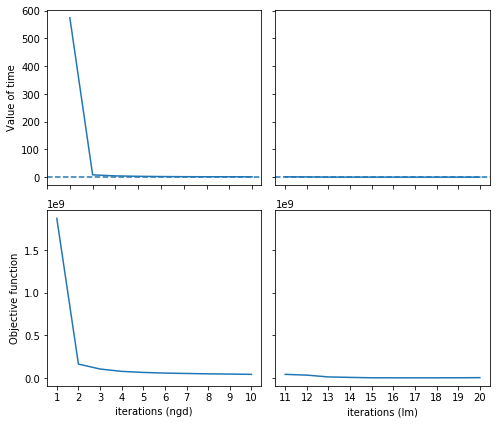

In [22]:
results_df = isl.descriptive_statistics \
    .get_loss_and_estimates_over_iterations(results_norefined=learning_results_norefined
                                            , results_refined=learning_results_refined)

fig = isl.visualization.Artist().convergence(
    results_norefined_df=results_df[results_df['stage'] == 'norefined'],
    results_refined_df=results_df[results_df['stage'] == 'refined'],
    simulated_data= True,
    filename='convergence_' + tntp_network.key,
    methods=[outer_optimizer_norefined.method.key, outer_optimizer_refined.method.key],
    theta_true = utility_function.true_values,
    folder = estimation_reporter.dirs['estimation_folder']
)

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'bilevel_optimization_convergence.pdf',
            pad_inches=0.1, bbox_inches="tight")

plt.show()

plt.close(fig)

### Distribution of errors across link counts

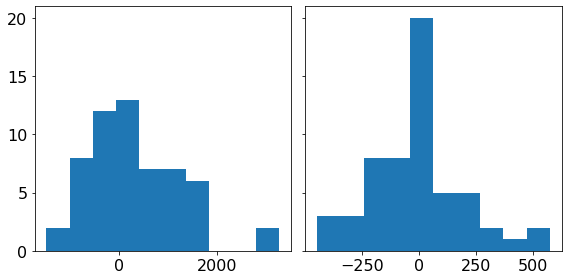

In [23]:
best_x_norefined = np.array(list(learning_results_norefined[best_iter_refined]['x'].values()))[:, np.newaxis]
best_x_refined = np.array(list(learning_results_refined[best_iter_refined]['x'].values()))[:, np.newaxis]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8, 4))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(isl.estimation.error_by_link(observed_counts=tntp_network.counts_vector, predicted_counts=best_x_norefined))
axs[1].hist(isl.estimation.error_by_link(observed_counts=tntp_network.counts_vector, predicted_counts=best_x_refined))

for axi in [axs[0], axs[1]]:
    axi.tick_params(axis='x', labelsize=16)
    axi.tick_params(axis='y', labelsize=16)

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'distribution_predicted_count_error.pdf',
            pad_inches=0.1, bbox_inches="tight")

plt.show()

plt.close(fig)

### Heatmap of O-D matrix

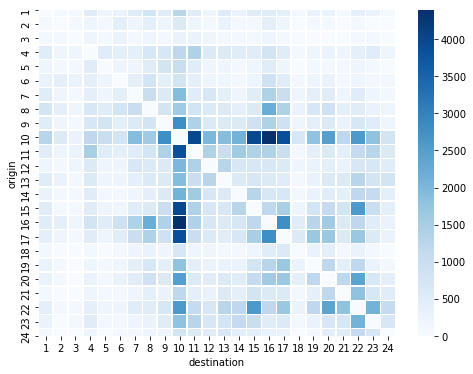

In [24]:
rows, cols = tntp_network.Q.shape

od_df = pd.DataFrame({'origin': pd.Series([], dtype=int)
                         , 'destination': pd.Series([], dtype=int)
                         , 'trips': pd.Series([], dtype=int)})

counter = 0
for origin in range(0, rows):
    for destination in range(0, cols):
        # od_df.loc[counter] = [(origin+1,destination+1), N['train'][current_network].Q[(origin,destination)]]
        od_df.loc[counter] = [int(origin + 1), int(destination + 1), tntp_network.Q[(origin, destination)]]
        counter += 1

od_df.origin = od_df.origin.astype(int)
od_df.destination = od_df.destination.astype(int)

od_pivot_df = od_df.pivot_table(index='origin', columns='destination', values='trips')

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(od_pivot_df, linewidth=0.5, cmap="Blues")

plt.show()

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'heatmap_OD_matrix.pdf',
            pad_inches=0.1, bbox_inches="tight")
plt.close(fig)